In [63]:
from physical_models import Annular
from bias_models import *
from run import main
from create import *
from plot_functions.plotResults import *

folder = 'results/Annular/'
figs_dir = folder + 'figs/'

os.makedirs(figs_dir, exist_ok=True)

1.953125e-05
Elapsed time =  11.216120719909668


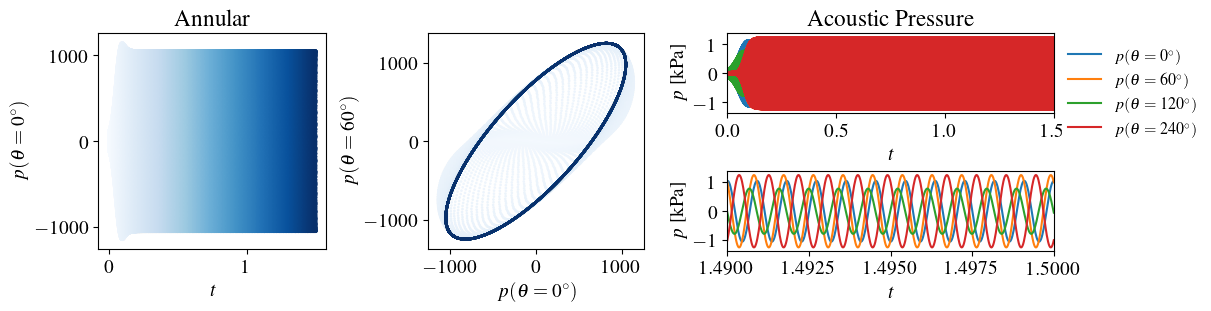

In [64]:
from plot_functions.plot_annular_model import *
plot_annular_model()

In [67]:
# %% ==================================== SELECT TRUE MODEL ======================================= #

ERs = 0.4875 + np.arange(0, 8) * 0.0125  # equivalence ratios 0.4875-0.575 (by steps of 0.0125)}

ER = ERs[2]

true_params = {'model': 'annular/ER_{}'.format(ER),
               'std_obs': 0.01
               }


In [68]:
# ==================================== SELECT FILTER PARAMETERS =================================== #
parameters_IC = dict(
    nu=(40., 50.),
    beta_c2=(40., 50.),
    kappa=(1.E-4, 1.3E-4),
    epsilon=(1E-3, 5E-3),
    omega=(1090 * 2 * np.pi, 1095 * 2 * np.pi),
    theta_b=(0.5, 0.7),
    theta_e=(0.4, 0.8),
)

filter_params = {'filter': 'rBA_EnKF',  # 'rBA_EnKF' 'EnKF' 'EnSRKF'
                 'constrained_filter': False,
                 'regularization_factor': 0.,
                 'm': 10,
                 # Parameter estimation options
                 'est_a': [*parameters_IC],
                 'std_a': parameters_IC,
                 'alpha_distr': 'uniform',
                 'std_psi': .5,
                 # Define the observation time window
                 't_start': 1.0,
                 't_stop': 1.05,
                 'dt_obs': 60,
                 # Inflation
                 'inflation': 1.00,
                 'reject_inflation': 1.00
                 }


truth = create_truth(true_params, filter_params)


 %% ================================= SELECT FORECAST MODEL ===================================== #

In [69]:
k = 1.2e-4
nu_1 = 633.77
nu_2 = -331.39
c2b_1 = 258.3
c2b_2 = -108.27

omega = 1090 * 2 * np.pi

# %initial values
C0 = 10
X0 = 0
th0 = 0.63
ph0 = 0

# %Conversion of the initial conditions from the quaternion formalism to the AB
# %formalism
Ai = C0 * np.sqrt(np.cos(th0)**2 * np.cos(X0)**2 + np.sin(th0)**2 * np.sin(X0)**2)
Bi = C0 * np.sqrt(np.sin(th0)**2 * np.cos(X0)**2 + np.cos(th0)**2 * np.sin(X0)**2)
phai = ph0 + np.arctan2(np.sin(th0) * np.sin(X0), np.cos(th0) * np.cos(X0))
phbi = ph0 - np.arctan2(np.cos(th0) * np.sin(X0), np.sin(th0) * np.cos(X0))

# %initial conditions for the fast oscillator equations
eai = Ai * np.cos(phai)
dteai = -omega * Ai * np.sin(phai)

ebi = Bi * np.cos(phbi)
dtebi = -omega * Bi * np.sin(phbi)

psi0 = [eai, dteai, ebi, dtebi]

print(psi0)

forecast_params = {'model': Annular,
                   'dt': truth['dt'],
                   'nu': nu_1*ER + nu_2,
                   'beta_c2': c2b_1*ER + c2b_2,
                   'omega': omega,
                   'psi0': psi0
                   }

[8.080275083121519, -0.0, 5.891447579422695, -0.0]


 %% ================================= SELECT BIAS MODEL ===================================== #

In [70]:
bias_params = {'biasType': NoBias,  # Bias.ESN / Bias.NoBias
               'std_a': filter_params['std_a'],
               'est_a': filter_params['est_a'],
               'augment_data': True,
               'upsample': 5,
               'L': 10,
               'N_wash': 20,
               'noise': 0.01,
               'rho_range': (0.5, 1.1),
               'sigma_in_range': (np.log10(1e-5), np.log10(1e0)),
               'tikh_range': [1e-16],
               }

 %% ================================= CORE OF THE CODE ===================================== #

In [71]:

ensemble = create_ensemble(forecast_params, filter_params)
filter_ens = ensemble.copy()

truth = create_truth(true_params, filter_params)


# START BIAS MODEL -----------------------------------------------------------
ESN_name = 'ESN_{}_L{}'.format(truth['name_bias'], bias_params['L'])
create_bias_model(filter_ens, truth, bias_params, ESN_name,
                  bias_model_folder=folder, plot_train_data=True)

# Add washout if needed ------------------------------------------------------

filter_ens = main(filter_ens, truth)




 ------------------ Annular Model Parameters ------------------ 
	 Nq = 4
	 beta_c2 = 45.0
	 epsilon = 0.003
	 kappa = 0.000115
	 n = 1.0
	 nu = 45.0
	 omega = 6864.38
	 theta_b = 0.6
	 theta_e = 0.6

 ----------------  Bias model parameters ----------------  
 Bias model: None

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = rBA_EnKF  
	 bias = None 
 	 m = 10 
 	 Time steps between analysis = 60 
 	 Inferred params = ['nu', 'beta_c2', 'kappa', 'epsilon', 'omega', 'theta_b', 'theta_e'] 
 	 Inflation = 1.0 
 	 Ensemble std(psi0) = 0.5
 	 Ensemble std(alpha0) = {'nu': (40.0, 50.0), 'beta_c2': (40.0, 50.0), 'kappa': (0.0001, 0.00013), 'epsilon': (0.001, 0.005), 'omega': (6848.671984825749, 6880.087911361647), 'theta_b': (0.5, 0.7), 'theta_e': (0.4, 0.8)}
 	 Number of analysis steps = 43, t0=0.99998046875, t1=1.04919921875
	 Bias penalisation factor k = 0.0

 --------------------------------------------
Elapsed time to first observation: 6.0097057819366455

 %% ================================= PLOT RESULTS ===================================== #

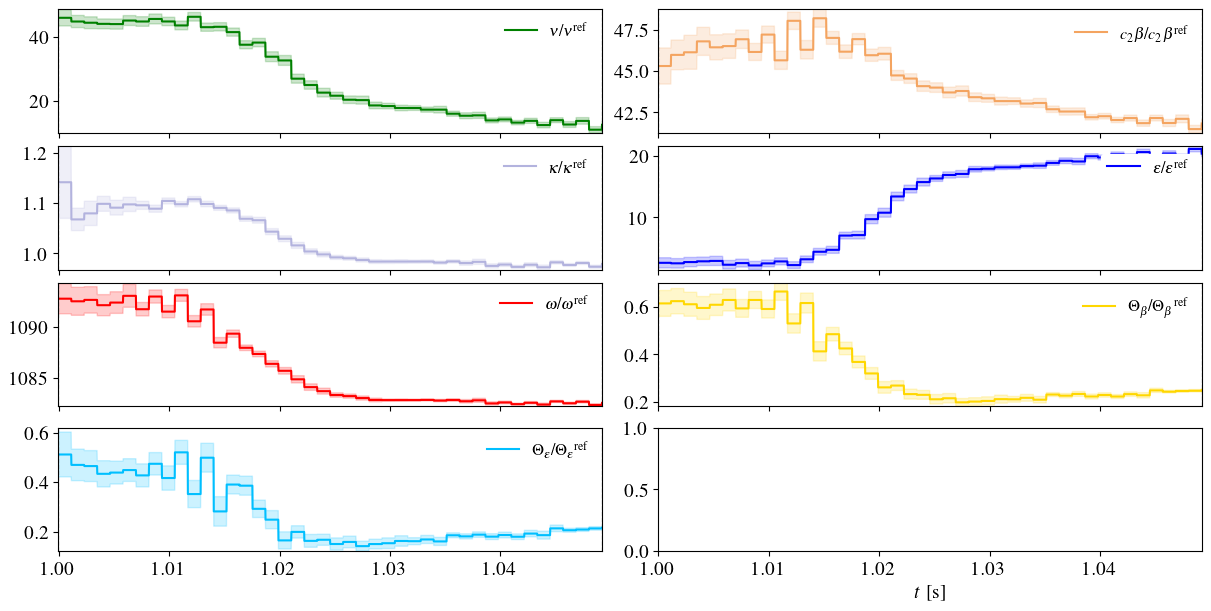

In [72]:
# Plot results -------
if filter_ens.est_a:
    reference_p = dict(omega=2 * np.pi,
                       kappa=1e-4,
                       epsilon=1e-3)

    plot_parameters(filter_ens, truth, reference_p=reference_p)


In [73]:

def plot_timeseries(filter_ens, truth, filename=None, reference_y=1., reference_t=1.):
    t_obs, obs = truth['t_obs'], truth['y_obs']

    y_filter, t = filter_ens.getObservableHist(), filter_ens.hist_t
    b, t_b = filter_ens.bias.hist, filter_ens.bias.hist_t
    y_mean = np.mean(y_filter, -1)

    # cut signals to interval of interest -----
    N_CR = int(filter_ens.t_CR // filter_ens.dt)  # Length of interval to compute correlation and RMS
    i0, i1 = [np.argmin(abs(t - truth['t_obs'][idx])) for idx in [0, -1]]  # start/end of assimilation

    y_unbiased = recover_unbiased_solution(t_b, b, t, y_mean, upsample=hasattr(filter_ens.bias, 'upsample'))
    y_filter, y_mean, y_unbiased, t = (yy[i0 - N_CR:i1 + N_CR] for yy in [y_filter, y_mean, y_unbiased, t])
    y_truth = interpolate(truth['t'], truth['y_noise'], t)

    if reference_t == 1.:
        t_label = '$t$ [s]'
        if 'wash_t' in truth.keys():
            t_wash, wash = truth['wash_t'], truth['wash_obs']
    else:
        t_label = '$t/T$'
        t, t_b, t_obs = [tt / reference_t for tt in [t, t_b, t_obs]]
        if 'wash_t' in truth.keys():
            t_wash, wash = truth['wash_t'] / reference_t, truth['wash_obs']

    # %% PLOT time series ------------------------------------------------------------------------------------------
    # norm = np.max(y_truth, axis=0)  # normalizing constant
    Nq = filter_ens.Nq

    fig1 = plt.figure(figsize=[9, 5.5], layout="constrained")
    subfigs = fig1.subfigures(1, 2, width_ratios=[1.1, 1])

    ax_zoom = subfigs[0].subplots(Nq, 2, sharex='col', sharey='row')
    ax_all = subfigs[1].subplots(Nq, 1, sharex='col')


    y_truth, y_unbiased, y_filter, y_mean, obs = [yy / reference_y for yy in [y_truth, y_unbiased, y_filter, y_mean, obs]] 

    margin = 0.5
    y_lims = [np.min(y_truth[:N_CR])  - margin, np.max(y_truth[:N_CR]) + margin]
    x_lims = [[t[0], t[0] + .5 * filter_ens.t_CR],
              [t[-1] - .5 * filter_ens.t_CR, t[-1]],
              [t[0], t[-1]]]

    for qi in range(Nq):

        for ax, xl in zip([ax_zoom[qi, 0], ax_zoom[qi, 1], ax_all[qi]], x_lims):

            # Observables ---------------------------------------------------------------------
            ax.plot(t, y_truth[:, qi], color=color_true, linewidth=5, label='t')
            ax.plot(t, y_unbiased[:, qi], '-', color=color_unbias, linewidth=1., label='u')
            for mi in range(y_filter.shape[-1]):
                ax.plot(t, y_filter[:, qi, mi], lw=.5, color='lightseagreen', alpha=0.5)
            ax.plot(t, y_mean[:, qi], '--', color=color_bias, linewidth=1, label='b')
            ax.plot(t_obs, obs[:, qi], '.', color=color_obs, markersize=6, label='o')
            ax.set(ylim=y_lims, xlim=xl)

            if 'wash_t' in truth.keys():
                ax.plot(t_wash, wash[:, qi], '.', color=color_obs, markersize=6)
            ax.plot((t_obs[0], t_obs[0]), (-1E6, 1E6), '--', color='k', linewidth=.8)  # DA window
            ax.plot((t_obs[-1], t_obs[-1]), (-1E6, 1E6), '--', color='k', linewidth=.8)  # DA window
            ax.set(xlim=xl)

        ylbl = '$y_{}$'.format(qi)
        if reference_y != 1.:
            ylbl += ' norm.'
        ax_zoom[qi, 0].set(ylabel=ylbl)

    ax_all[0].legend(loc='upper left', bbox_to_anchor=(0., 1.1), ncol=5, fontsize='xx-small')
    for ax in [ax_zoom[-1, 0], ax_zoom[-1, 1], ax_all[-1]]:
        ax.set(xlabel=t_label)

    if filename is not None:
        plt.savefig(filename + '.svg', dpi=350)
        plt.close()


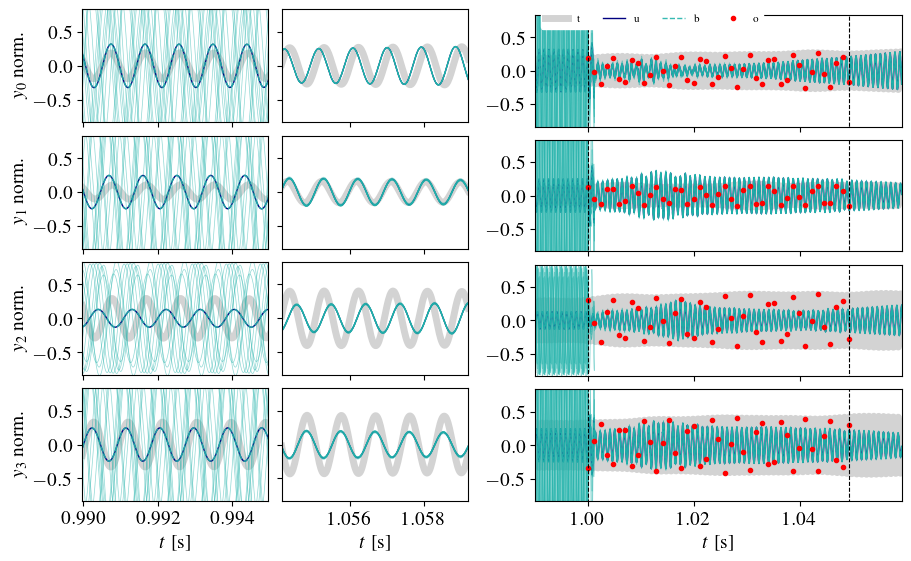

In [74]:

plot_timeseries(filter_ens, truth, reference_y=1000.)